In [1]:
import pandas as pd
import numpy as np

import folium

from src.manage_precipitation_data import create_tp_daily_summary, create_tp_monthly_aggregate

# ERA5 Processing Geospatial Data Points To Daily Summary

> Writing the scope and purpose of this notebook. This notebook it's about processing precipitation data. As this use `geopandas`, I am using a different Python Conda Environment - This notebook will be renamed and eventually integrated with what I did in `process_precipitation_data`. The reason for this notebook was to calculate the spatial coordinates belonging to Apulia region. From a strategic point of view, I can calculate the points in the Apulia region in this notebook and save them into a dataframe. This dataframe will be used it `process_precipitation_data` to produce the filtered dataset for Apulia region. The issue with long format, is the fact it's already computing the mean for all points, also the one outside the region. I need to create a notebook for spatial data visualization.

In this notebook we process the long format dataset created from `grib` files into hourly and daily summaries. For each year, 2 parquet files are produced, containing hourly and daily measurements. The daily measurement are hourly cumulative sums for each hour. 

For Apulia region, as the grib files contain measurements collected in a grid of points, we filter data checking that all points in the grid belong to that region.

## Processing Dataset

In [2]:
import pandas as pd
import numpy as np

import folium

from src.manage_precipitation_data import create_tp_daily_summary, create_tp_monthly_aggregate

import geopandas as gpd
from shapely.geometry import Point

# Load the shapefile
italy_regions = gpd.read_file("./gadm41_ITA_shp/gadm41_ITA_1.shp")


def create_list_lat_long(df_data):
    lats = df_data['latitude'].unique()
    lons = df_data['longitude'].unique()

    lat_long = []

    for lat in lats:
        for lon in lons:
            df = df_data[(df_data['latitude'] == lat) &
                                    (df_data['longitude'] == lon)]
            if df.shape[0] != 0:

                lat_long.append((lat,lon))

    return(lat_long)


def filter_apulia_points(df_data):
    df = df_data.copy()
    italy_regions = gpd.read_file("./gadm41_ITA_shp/gadm41_ITA_1.shp")

    # Filter Puglia region 
    puglia = italy_regions[italy_regions['NAME_1'].str.contains('Apulia', case=False)]

    # Check the geometry
    puglia_polygon = puglia.geometry.iloc[0]

    # Filter Puglia region (sometimes name might have accents or different cases)
    puglia = italy_regions[italy_regions['NAME_1'].str.contains('Apulia', case=False)]

    # Check the geometry (should be a Polygon or MultiPolygon)
    puglia_polygon = puglia.geometry.iloc[0]

    lat_long = create_list_lat_long(df)
    # Check whether points fall inside Puglia
    coor_in = []
    for coord in lat_long:
        lat, lon = coord
        point = Point(lon, lat)  # Note: (lon, lat) order for Point
        if puglia_polygon.contains(point):
            coor_in.append(coord)
 
    df_apulia_points = pd.DataFrame(coor_in, columns=['latitude', 'longitude'])
    df_filtered = pd.merge(df_apulia_points, df,
                           how = 'left',
                           on = ['latitude', 'longitude']
                           )
    return df_filtered

# transform original data 
# filter for the daily cumsum
# if 'puglia', filter for lat, lon belonging in apulia
# drop redundant columns

def transform_original_dataset(df_data, area = 'london', year = 2025):
    '''
    transform original data 
        1. if 'puglia', filter for lat, lon belonging in apulia
        2. saving from csv to parquet the original data file
        3. filter for the daily cumsum
        4. creating tp_mm column
        5. drop redundant columns
    '''

    # 1. filtering points for Apulia region
    if area == 'puglia':
        df_data = filter_apulia_points(df_data)

    # 2. saving original file as pkl removing redundant columns
#    fname = './output/' +  str(year) + '_' + area + '_' + '24h_data.pkl'
    fname_p = './output/' +  str(year) + '_' + area + '_' + '24h_data.parquet'

#     df_data[['time','valid_time', 'step', 'latitude', 'longitude', 'tp']].to_pickle(fname)
    df_data[['time','valid_time', 'step', 'latitude', 'longitude', 'tp']].to_parquet(fname_p)
    print(f"{fname_p} saved")
    
    # 3. When step starts with 1, it means that we have the cumulative sum for that day
    data_step_1 = df_data[df_data['step'].str.startswith('1')].copy()

    # 4. Creating tp_mm column
    data_step_1['tp_mm'] = data_step_1['tp']*1000
    data_step_1['time_dt'] = pd.to_datetime(data_step_1['time'])

    data_step_1.loc[data_step_1['tp_mm'] < 0.1, 'tp_mm'] = 0.
    data_step_1['tp_mm'] = np.round(data_step_1['tp_mm'], 1)

    # 5. drop redundant columns
    data_step_1.drop(['step', 'number', 'surface', 'valid_time'], axis=1, inplace=True)
#    fname = './output/' +  str(year) + '_' + area + '_' + 'daily_data.pkl'
    fname_p = './output/' +  str(year) + '_' + area + '_' + 'daily_data.parquet'
#    data_step_1.to_pickle(fname)
    data_step_1.to_parquet(fname_p)
    print(f"{fname_p} saved")
    return(data_step_1)

# compute the daily mean for each point in the grid
def create_daily_tp_mean(df_all_points):
    df_mean = (df_all_points.groupby('time_dt')[['tp', 'tp_mm']].mean()).reset_index()
    return(df_mean)
    

def create_daily_tp_list(df_data, year = 2025):
    # collecting all possible combination of lat, long in the dataset

    lat_long = create_list_lat_long(df_data)
    
    # creating the list of dataframes
    dfs_tp_daily_data_2020 = []

    for coord in lat_long:
        df = df_data[(df_data['latitude'] == coord[0]) &
                        (df_data['longitude'] == coord[1])].reset_index(drop = True)
        dfs_tp_daily_data_2020.append(df)

    return(dfs_tp_daily_data_2020)

def create_yearly_sum_from_list(dfs_list):
    lats = []
    lons = []
    tp_sums = []
    tp_mm_sums = []
    for i in np.arange(0, len(dfs_list)):
        lats.append(dfs_list[i]['latitude'].unique()[0])
        lons.append(dfs_list[i]['longitude'].unique()[0])
        tp_sums.append(dfs_list[i]['tp'].sum())
        tp_mm_sums.append(dfs_list[i]['tp_mm'].sum())
    df_yearly_sums = pd.DataFrame({
        'latitude' : lats,
        'longitude' : lons,
        'tp_yearly_sum' : tp_sums,
        'tp_mm_yearly_sum' : tp_mm_sums
    })
    return(df_yearly_sums)

## Example with Apulia dataset

- check differences in `.pkl` sizes with `transform_original_dataset` and `create_daily_tp_list`

In [4]:
first_year = 2000
latest_year = 2009
years = np.arange(first_year, latest_year +1)
area = 'puglia'

base_path = './data/'
for y in years:
    fname = base_path + str(y) + '_' + area + '_era5_precipitation_long_format.csv'
    df = pd.read_csv(fname,comment= '#')
    t = transform_original_dataset(df, area=area,year=y)
    print(fname)

./output/2000_puglia_24h_data.parquet saved
./output/2000_puglia_daily_data.parquet saved
./data/2000_puglia_era5_precipitation_long_format.csv
./output/2001_puglia_24h_data.parquet saved
./output/2001_puglia_daily_data.parquet saved
./data/2001_puglia_era5_precipitation_long_format.csv
./output/2002_puglia_24h_data.parquet saved
./output/2002_puglia_daily_data.parquet saved
./data/2002_puglia_era5_precipitation_long_format.csv
./output/2003_puglia_24h_data.parquet saved
./output/2003_puglia_daily_data.parquet saved
./data/2003_puglia_era5_precipitation_long_format.csv
./output/2004_puglia_24h_data.parquet saved
./output/2004_puglia_daily_data.parquet saved
./data/2004_puglia_era5_precipitation_long_format.csv
./output/2005_puglia_24h_data.parquet saved
./output/2005_puglia_daily_data.parquet saved
./data/2005_puglia_era5_precipitation_long_format.csv
./output/2006_puglia_24h_data.parquet saved
./output/2006_puglia_daily_data.parquet saved
./data/2006_puglia_era5_precipitation_long_for

In [5]:
years = np.arange(2000, 2010)
area = 'london'

base_path = './data/'
for y in years:
    fname = base_path + str(y) + '_' + area + '_era5_precipitation_long_format.csv'
    df = pd.read_csv(fname,comment= '#')
    t = transform_original_dataset(df, area=area,year=y)
    print(fname)

./output/2000_london_24h_data.parquet saved
./output/2000_london_daily_data.parquet saved
./data/2000_london_era5_precipitation_long_format.csv
./output/2001_london_24h_data.parquet saved
./output/2001_london_daily_data.parquet saved
./data/2001_london_era5_precipitation_long_format.csv
./output/2002_london_24h_data.parquet saved
./output/2002_london_daily_data.parquet saved
./data/2002_london_era5_precipitation_long_format.csv
./output/2003_london_24h_data.parquet saved
./output/2003_london_daily_data.parquet saved
./data/2003_london_era5_precipitation_long_format.csv
./output/2004_london_24h_data.parquet saved
./output/2004_london_daily_data.parquet saved
./data/2004_london_era5_precipitation_long_format.csv
./output/2005_london_24h_data.parquet saved
./output/2005_london_daily_data.parquet saved
./data/2005_london_era5_precipitation_long_format.csv
./output/2006_london_24h_data.parquet saved
./output/2006_london_daily_data.parquet saved
./data/2006_london_era5_precipitation_long_for

In [6]:
t

,time,latitude,longitude,tp,tp_mm,time_dt
0,2024-12-31,51.6,-2.000000e-01,0.000065,0.0,2024-12-31
1,2024-12-31,51.6,-1.000000e-01,0.000060,0.0,2024-12-31
2,2024-12-31,51.6,2.775558e-17,0.000054,0.0,2024-12-31
3,2024-12-31,51.6,1.000000e-01,0.000043,0.0,2024-12-31
4,2024-12-31,51.5,-2.000000e-01,0.000124,0.1,2024-12-31
...,...,...,...,...,...,...
50983,2025-06-26,51.5,1.000000e-01,0.001623,1.6,2025-06-26
50984,2025-06-26,51.4,-2.000000e-01,0.001196,1.2,2025-06-26
50985,2025-06-26,51.4,-1.000000e-01,0.001359,1.4,2025-06-26
50986,2025-06-26,51.4,2.775558e-17,0.001538,1.5,2025-06-26


In [ ]:
## London Dataset

data_london_2018_lf = pd.read_csv('./data/2018_london_era5_precipitation_long_format.csv',
                                    comment= '#')
tp = transform_original_dataset(data_london_2018_lf, area='london', year=2018)


In [9]:
years = [2018,2019,2020]
area = 'london'
base_folder = './data/'

for year in years:
    fname = str(year) + '_' + area + '_era5_precipitation_long_format.csv'
    filename = base_folder + fname
    lf_data = pd.read_csv(filename, comment = '#')
    tp = transform_original_dataset(lf_data, area=area, year=year)
    print(filename)

./output/2018_london_24h_data.parquet saved
./output/2018_london_daily_data.parquet saved
./data/2018_london_era5_precipitation_long_format.csv
./output/2019_london_24h_data.parquet saved
./output/2019_london_daily_data.parquet saved
./data/2019_london_era5_precipitation_long_format.csv
./output/2020_london_24h_data.parquet saved
./output/2020_london_daily_data.parquet saved
./data/2020_london_era5_precipitation_long_format.csv


In [3]:
data_puglia_2018 = pd.read_pickle('./output/2018_puglia_24h_data.pkl')
data_puglia_2018.shape

(1550520, 6)

In [18]:
data_puglia_2018 = pd.read_pickle('./output/2018_puglia_daily_data.pkl')
data_puglia_2018.tail()

,latitude,longitude,time,tp,tp_mm,time_dt
1550400,40.2,18.4,2018-12-26,4.261732e-07,0.0,2018-12-26
1550424,40.2,18.4,2018-12-27,8.463859e-07,0.0,2018-12-27
1550448,40.2,18.4,2018-12-28,4.541524e-05,0.0,2018-12-28
1550472,40.2,18.4,2018-12-29,3.706693e-05,0.0,2018-12-29
1550496,40.2,18.4,2018-12-30,1.581520e-04,0.2,2018-12-30


In [19]:
data_puglia_2019 = pd.read_pickle('./output/2019_puglia_daily_data.pkl')
data_puglia_2019.head()

,latitude,longitude,time,tp,tp_mm,time_dt
0,41.9,15.4,2018-12-31,0.001683,1.7,2018-12-31
24,41.9,15.4,2019-01-01,0.000641,0.6,2019-01-01
48,41.9,15.4,2019-01-02,0.007732,7.7,2019-01-02
72,41.9,15.4,2019-01-03,0.004911,4.9,2019-01-03
96,41.9,15.4,2019-01-04,0.007807,7.8,2019-01-04


In [16]:
test_data = create_list_lat_long(data_puglia_2022)

In [17]:
len(test_data)

177

In [11]:
177*366

64782

In [36]:
data_puglia_2022.dtypes

latitude            float64
longitude           float64
time                 object
tp                  float64
tp_mm               float64
time_dt      datetime64[ns]
dtype: object

In [37]:
data_puglia_2022.head()

,latitude,longitude,time,tp,tp_mm,time_dt
0,41.9,15.4,2021-12-31,8.523463e-07,0.0,2021-12-31
24,41.9,15.4,2022-01-01,2.139806e-06,0.0,2022-01-01
48,41.9,15.4,2022-01-02,2.661347e-05,0.0,2022-01-02
72,41.9,15.4,2022-01-03,1.107070e-04,0.1,2022-01-03
96,41.9,15.4,2022-01-04,0.000000e+00,0.0,2022-01-04


In [40]:
test_mean = (data_puglia_2022.groupby('time_dt')[['tp', 'tp_mm']].mean()).reset_index()

In [41]:
test_mean['tp'].sum()

np.float64(0.6000393004783842)

In [42]:
test_mean['tp_mm'].sum()

np.float64(597.7141242937853)

time_dt    datetime64[ns]
tp                float64
tp_mm             float64
dtype: object

In [ ]:
dfs_puglia = create_daily_tp_list(data_puglia_2022)

In [53]:
df_test_y = create_yearly_sum_from_list(dfs_puglia)
df_test_y[['tp_yearly_sum', 'tp_mm_yearly_sum']].mean()

tp_yearly_sum         0.600039
tp_mm_yearly_sum    597.714124
dtype: float64

In [ ]:
# data_puglia_2022.to_pickle('test.pkl')

In [9]:
test = create_daily_tp_list(data_puglia_2022_lf, area='puglia')

In [17]:
test[0].head()

,latitude,longitude,time,tp,tp_mm,time_dt
0,41.9,15.4,2021-12-31,8.523463e-07,0.0,2021-12-31
24,41.9,15.4,2022-01-01,2.139806e-06,0.0,2022-01-01
48,41.9,15.4,2022-01-02,2.661347e-05,0.0,2022-01-02
72,41.9,15.4,2022-01-03,1.107070e-04,0.1,2022-01-03
96,41.9,15.4,2022-01-04,0.000000e+00,0.0,2022-01-04


In [19]:
for i in np.arange(20, 25):
    print(f"({test[i]['latitude'].unique()[0], test[i]['longitude'].unique()[0]}) tot precipitation = {test[i]['tp_mm'].sum()}")    
    

((np.float64(41.7), np.float64(15.3))) tot precipitation = 629.7
((np.float64(41.7), np.float64(15.6))) tot precipitation = 630.3
((np.float64(41.7), np.float64(15.7))) tot precipitation = 638.6
((np.float64(41.6), np.float64(15.4))) tot precipitation = 606.9000000000001
((np.float64(41.6), np.float64(15.5))) tot precipitation = 606.4000000000001


In [25]:
# Long format files contains all measurements for each point of the grid

data_london_2020_lf = pd.read_csv('./data/2020_london_era5_precipitation_long_format.csv',comment = '#')
data_london_2020_lf.shape

(105408, 8)

In [26]:
london_2022_list = create_daily_tp_list(data_london_2020_lf)

In [30]:
data_puglia_2022_lf = pd.read_csv('./data/2022_puglia_era5_precipitation_long_format.csv',comment = '#')
data_puglia_2022_lf.shape

(2680560, 8)

In [ ]:
puglia_2022_list = create_daily_tp_list(data_puglia_2022_lf, area = 'london')

In [29]:
test = create_list_lat_long(data_puglia_2022_lf)
len(test)

306

In [22]:
puglia_2022_list[2]

,time,latitude,longitude,tp,tp_mm,time_dt
2,2021-12-31,41.9,15.8,2.580881e-06,0.0,2021-12-31
7346,2022-01-01,41.9,15.8,1.722574e-06,0.0,2022-01-01
14690,2022-01-02,41.9,15.8,1.545250e-05,0.0,2022-01-02
22034,2022-01-03,41.9,15.8,1.304361e-04,0.1,2022-01-03
29378,2022-01-04,41.9,15.8,8.642673e-07,0.0,2022-01-04
...,...,...,...,...,...,...
2643842,2022-12-26,41.9,15.8,2.359152e-05,0.0,2022-12-26
2651186,2022-12-27,41.9,15.8,2.580881e-06,0.0,2022-12-27
2658530,2022-12-28,41.9,15.8,1.072884e-05,0.0,2022-12-28
2665874,2022-12-29,41.9,15.8,4.321337e-07,0.0,2022-12-29


In [3]:
# collecting all possible combination of lat, long in the dataset

lats = data_london_2020_lf['latitude'].unique()
lons = data_london_2020_lf['longitude'].unique()
# latit = []
# longit = []
lat_long = []

for lat in lats:
    for lon in lons:
        df = data_london_2020_lf[(data_london_2020_lf['latitude'] == lat) &
                                 (data_london_2020_lf['longitude'] == lon)]
        if df.shape[0] != 0:
            # print(f"lat = {lat}, lon = {lon}, df_shape = {df.shape}")
            # latit.append(lat)
            # longit.append(lon)
            lat_long.append((lat,lon))

In [44]:
# When step starts with 1, it means that we have the cumulative sum for that day
data_step_1 = data_london_2020_lf[data_london_2020_lf['step'].str.startswith('1')].copy()

data_step_1.dtypes

time           object
step           object
latitude      float64
longitude     float64
number          int64
surface       float64
valid_time     object
tp            float64
dtype: object

In [45]:
data_step_1.head()

,time,step,latitude,longitude,number,surface,valid_time,tp
0,2019-12-31,1 days 00:00:00,51.6,-2.000000e-01,0,0.0,2020-01-01 00:00:00,0.000048
1,2019-12-31,1 days 00:00:00,51.6,-1.000000e-01,0,0.0,2020-01-01 00:00:00,0.000044
2,2019-12-31,1 days 00:00:00,51.6,2.775558e-17,0,0.0,2020-01-01 00:00:00,0.000041
3,2019-12-31,1 days 00:00:00,51.6,1.000000e-01,0,0.0,2020-01-01 00:00:00,0.000043
4,2019-12-31,1 days 00:00:00,51.5,-2.000000e-01,0,0.0,2020-01-01 00:00:00,0.000043


In [46]:
data_step_1['tp_mm'] = data_step_1['tp']*1000
data_step_1['time_dt'] = pd.to_datetime(data_step_1['time'])

data_step_1.loc[data_step_1['tp_mm'] < 0.1, 'tp_mm'] = 0.
data_step_1['tp_mm'] = np.round(data_step_1['tp_mm'], 1)

data_step_1.drop(['step', 'number', 'surface', 'valid_time'], axis=1, inplace=True)

In [55]:
data_step_1.columns

Index(['time', 'latitude', 'longitude', 'tp', 'tp_mm', 'time_dt'], dtype='object')

In [56]:
dfs_london_tp_daily_data_2020 = []

for coord in lat_long:
    df = data_step_1[(data_step_1['latitude'] == coord[0]) &
                     (data_step_1['longitude'] == coord[1])]
    print(df.shape)
    dfs_london_tp_daily_data_2020.append(df)

(366, 6)
(366, 6)
(366, 6)
(366, 6)
(366, 6)
(366, 6)
(366, 6)
(366, 6)
(366, 6)
(366, 6)
(366, 6)
(366, 6)


In [98]:
lat = []
lon = []
tp_sum = []

for i in np.arange(0,len(dfs_london_tp_daily_data_2020)):
    lat.append(dfs_london_tp_daily_data_2020[i]['latitude'].unique()[0])
    lon.append(dfs_london_tp_daily_data_2020[i]['longitude'].unique()[0])
    tp_sum.append(dfs_london_tp_daily_data_2020[i]['tp_mm'].sum())

london_yearly_tp_points = pd.DataFrame({
    'latitude' : lat,
    'longitude' : lon,
    'yearly_tp_mm' : tp_sum
})

london_yearly_tp_points

,latitude,longitude,yearly_tp_mm
0,51.6,-2.000000e-01,705.0
1,51.6,-1.000000e-01,699.1
2,51.6,2.775558e-17,694.1
3,51.6,1.000000e-01,687.1
4,51.5,-2.000000e-01,721.2
5,51.5,-1.000000e-01,716.3
6,51.5,2.775558e-17,710.1
7,51.5,1.000000e-01,703.7
8,51.4,-2.000000e-01,743.6
9,51.4,-1.000000e-01,744.7


We now want to check if we compute the mean of total precipitation per day, and sum up through the year, we will have a sound result.

In [69]:
data_step_2 = data_step_1.copy()

In [ ]:
data_step_2['lat_lon'] = data_step_2['latitude'].astype(str) + ', ' + np.round(data_step_2['longitude'],1).astype(str)
data_step_2.head(15)

,time,latitude,longitude,tp,tp_mm,time_dt,lat_lon
0,2019-12-31,51.6,-2.000000e-01,0.000048,0.0,2019-12-31,"51.6, -0.2"
1,2019-12-31,51.6,-1.000000e-01,0.000044,0.0,2019-12-31,"51.6, -0.1"
2,2019-12-31,51.6,2.775558e-17,0.000041,0.0,2019-12-31,"51.6, 0.0"
3,2019-12-31,51.6,1.000000e-01,0.000043,0.0,2019-12-31,"51.6, 0.1"
4,2019-12-31,51.5,-2.000000e-01,0.000043,0.0,2019-12-31,"51.5, -0.2"
5,2019-12-31,51.5,-1.000000e-01,0.000039,0.0,2019-12-31,"51.5, -0.1"
6,2019-12-31,51.5,2.775558e-17,0.000035,0.0,2019-12-31,"51.5, 0.0"
7,2019-12-31,51.5,1.000000e-01,0.000036,0.0,2019-12-31,"51.5, 0.1"
8,2019-12-31,51.4,-2.000000e-01,0.000037,0.0,2019-12-31,"51.4, -0.2"
9,2019-12-31,51.4,-1.000000e-01,0.000031,0.0,2019-12-31,"51.4, -0.1"


In [92]:
(data_step_2
 .groupby(['time_dt'])['tp_mm']
 .mean()
).reset_index()['tp_mm'].sum()

np.float64(717.0416666666667)

In [99]:
london_yearly_tp_points['yearly_tp_mm'].mean()

np.float64(717.0416666666669)

In [26]:
data_step_1.head()

,time,latitude,longitude,tp_mm,time_dt
0,2019-12-31,51.6,-2.000000e-01,0.047940,2019-12-31
1,2019-12-31,51.6,-1.000000e-01,0.044453,2019-12-31
2,2019-12-31,51.6,2.775558e-17,0.040787,2019-12-31
3,2019-12-31,51.6,1.000000e-01,0.043410,2019-12-31
4,2019-12-31,51.5,-2.000000e-01,0.043499,2019-12-31


In [116]:
lat = []
lon = []

for coord in lat_long:
    lat.append(coord[0])
    lon.append(coord[1])

london_coordinates = pd.DataFrame({
    'latitude' : lat,
    'longitude' : lon  
})


In [120]:
# Create a base map centered on your data
center_lat = london_coordinates['latitude'].mean()
center_lon = london_coordinates['longitude'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

# Add circles to the map
for idx, row in london_coordinates.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=8,
        popup=f"lat: {np.round(row['latitude'])} lon: {np.round(row['longitude'],1)}",
        fill=True,
        fillOpacity=0.7
    ).add_to(m)

# Display the map
m

In [108]:
london_yearly_tp_points['yearly_tp_mm'].mean()

np.float64(717.0416666666669)

In [115]:
tp_yearly_mean = london_yearly_tp_points['yearly_tp_mm'].mean()

# Create a base map centered on your data
center_lat = london_yearly_tp_points['latitude'].mean()
center_lon = london_yearly_tp_points['longitude'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

# Define color mapping based on tp_mm values
def get_color(tp_mm_value, tp_yearly_mean):
    if tp_mm_value < tp_yearly_mean:
        return 'orange'
    else:
        return 'blue'

# Add circles to the map
for idx, row in london_yearly_tp_points.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=13,
        popup=f"({row['latitude'], row['longitude'] }) tp_mm: {row['yearly_tp_mm']}",
        color=get_color(row['yearly_tp_mm'], tp_yearly_mean),
        fill=True,
        fillColor=get_color(row['yearly_tp_mm'], tp_yearly_mean),
        fillOpacity=0.7
    ).add_to(m)

# Display the map
m

In [ ]:
# Create a base map centered on your data
center_lat = df_map_apulia['lat'].mean()
center_lon = df_map_apulia['lon'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=6)

# Define color mapping based on tp_mm values
def get_color(tp_mm_value):
    if tp_mm_value < 490:
        return 'blue'
    elif tp_mm_value < 600:
        return 'green'
    elif tp_mm_value < 750:
        return 'yellow'
    else:
        return 'red'

# Add circles to the map
for idx, row in df_map_apulia.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=8,
        popup=f"tp_mm: {row['tp_mm_year_2022']}",
        color=get_color(row['tp_mm_year_2022']),
        fill=True,
        fillColor=get_color(row['tp_mm_year_2022']),
        fillOpacity=0.7
    ).add_to(m)

# Display the map
m

In [110]:
12*24*366

105408

In [105]:
## Puglia Coordinates

In [2]:
data_puglia_2020_lf = pd.read_csv('./data/2020_puglia_era5_precipitation_long_format.csv',comment = '#')
data_puglia_2020_lf.shape

(2687904, 8)

In [3]:
# collecting all possible combination of lat, long in the dataset

lats = data_puglia_2020_lf['latitude'].unique()
lons = data_puglia_2020_lf['longitude'].unique()
# latit = []
# longit = []
lat_long = []

for lat in lats:
    for lon in lons:
        df = data_puglia_2020_lf[(data_puglia_2020_lf['latitude'] == lat) &
                                 (data_puglia_2020_lf['longitude'] == lon)]
        if df.shape[0] != 0:
            # print(f"lat = {lat}, lon = {lon}, df_shape = {df.shape}")
            # latit.append(lat)
            # longit.append(lon)
            lat_long.append((lat,lon))

In [4]:
lats = data_puglia_2020_lf['latitude'].unique()
lons = data_puglia_2020_lf['longitude'].unique()
latit = []
longit = []
tp_sum = []

for lat in lats:
    for lon in lons:
        df = data_puglia_2020_lf[(data_puglia_2020_lf['latitude'] == lat) &
                                 (data_puglia_2020_lf['longitude'] == lon)]
        if df.shape[0] != 0:
            # print(f"lat = {lat}, lon = {lon}, df_shape = {df.shape}")
            latit.append(lat)
            longit.append(lon)
            df_data = df[(df['latitude'] == lat) & (df['longitude'] == lon)].copy()
            test = create_tp_daily_summary(df_data, year=2020)
            tp_sum.append(test['tp_mm'].sum())

df_map = pd.DataFrame(
        {
        'latitude' : latit,
        'longitude' : longit,
        'tp_mm_year_2022' : tp_sum
        }
        )

In [5]:
df_map.head()

,latitude,longitude,tp_mm_year_2022
0,41.9,15.4,525.3
1,41.9,15.5,541.9
2,41.9,15.8,591.9
3,41.9,15.9,551.9
4,41.9,16.0,524.2


In [9]:
lat_long[0]

(np.float64(41.9), np.float64(15.4))

In [53]:
import geopandas as gpd
from shapely.geometry import Point

# Load the shapefile

def filter_apulia_points(df):

    italy_regions = gpd.read_file("./gadm41_ITA_shp/gadm41_ITA_1.shp")

    # Filter Puglia region 
    puglia = italy_regions[italy_regions['NAME_1'].str.contains('Apulia', case=False)]

    # Check the geometry
    puglia_polygon = puglia.geometry.iloc[0]

    # Filter Puglia region (sometimes name might have accents or different cases)
    puglia = italy_regions[italy_regions['NAME_1'].str.contains('Apulia', case=False)]

    # Check the geometry (should be a Polygon or MultiPolygon)
    puglia_polygon = puglia.geometry.iloc[0]

    lat_long = create_list_lat_long(df)
    # Check whether points fall inside Puglia
    coor_in = []
    point_in = []

    for coord in lat_long:
        lat, lon = coord
        point = Point(lon, lat)  # Note: (lon, lat) order for Point
        if puglia_polygon.contains(point):
            coor_in.append(coord)
    #        point_in.append(point)
    #        print(f"Coordinate {coord} is inside Puglia.")
    #    else:
    #        print(f"Coordinate {coord} is NOT inside Puglia.")

    df_apulia_points = pd.DataFrame(coor_in, columns=['latitude', 'longitude'])
    df_filtered = pd.merge(df_apulia_points, data_puglia_2022_lf,
                           how = 'left',
                           on = ['latitude', 'longitude']
                           )
    return df_filtered

In [54]:
test_df = filter_apulia_points(data_puglia_2022_lf)

In [56]:
test_df.head()

,latitude,longitude,time,step,number,surface,valid_time,tp
0,41.9,15.4,2021-12-31,1 days 00:00:00,0,0.0,2022-01-01 00:00:00,8.523463e-07
1,41.9,15.4,2022-01-01,0 days 01:00:00,0,0.0,2022-01-01 01:00:00,0.000000e+00
2,41.9,15.4,2022-01-01,0 days 02:00:00,0,0.0,2022-01-01 02:00:00,0.000000e+00
3,41.9,15.4,2022-01-01,0 days 03:00:00,0,0.0,2022-01-01 03:00:00,0.000000e+00
4,41.9,15.4,2022-01-01,0 days 04:00:00,0,0.0,2022-01-01 04:00:00,0.000000e+00


In [48]:
test_01_data_puglia = pd.merge(p_in, data_puglia_2022_lf,
                               how = 'left',
                               on = ['latitude', 'longitude']
                               )

In [49]:
test_01_data_puglia.shape

(1550520, 8)

In [52]:
test_01_data_puglia.head()

,latitude,longitude,time,step,number,surface,valid_time,tp
0,41.9,15.4,2021-12-31,1 days 00:00:00,0,0.0,2022-01-01 00:00:00,8.523463e-07
1,41.9,15.4,2022-01-01,0 days 01:00:00,0,0.0,2022-01-01 01:00:00,0.000000e+00
2,41.9,15.4,2022-01-01,0 days 02:00:00,0,0.0,2022-01-01 02:00:00,0.000000e+00
3,41.9,15.4,2022-01-01,0 days 03:00:00,0,0.0,2022-01-01 03:00:00,0.000000e+00
4,41.9,15.4,2022-01-01,0 days 04:00:00,0,0.0,2022-01-01 04:00:00,0.000000e+00


In [42]:
c_in[0]

(np.float64(41.9), np.float64(15.4))

In [15]:
puglia

,GID_1,GID_0,COUNTRY,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,geometry
1,ITA.2_1,ITA,Italy,Apulia,Apulien|Pouilles|Pouille|Puglia|,NA,Regione,Region,16,NA,NA,"MULTIPOLYGON (((18.39319 39.86014, 18.39319 39..."


In [ ]:
# Filter Puglia region (sometimes name might have accents or different cases)
puglia = italy_regions[italy_regions['NAME_1'].str.contains('Apulia', case=False)]



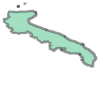

In [17]:
puglia_polygon

In [ ]:
# Filter Puglia region (sometimes name might have accents or different cases)
puglia = italy_regions[italy_regions['NAME_1'].str.contains('Apulia', case=False)]

# Check the geometry (should be a Polygon or MultiPolygon)
puglia_polygon = puglia.geometry.iloc[0]

# Check whether points fall inside Puglia
coor_in = []
point_in = []

for coord in lat_long:
    lat, lon = coord
    point = Point(lon, lat)  # Note: (lon, lat) order for Point
    if puglia_polygon.contains(point):
        coor_in.append(coord)
        point_in.append(point)
#        print(f"Coordinate {coord} is inside Puglia.")
    else:
        print(f"Coordinate {coord} is NOT inside Puglia.")

Coordinate (np.float64(41.8), np.float64(16.2)) is NOT inside Puglia.
Coordinate (np.float64(41.39999999999999), np.float64(16.099999999999998)) is NOT inside Puglia.
Coordinate (np.float64(41.19999999999999), np.float64(16.700000000000006)) is NOT inside Puglia.
Coordinate (np.float64(41.09999999999999), np.float64(15.4)) is NOT inside Puglia.
Coordinate (np.float64(41.09999999999999), np.float64(15.9)) is NOT inside Puglia.
Coordinate (np.float64(41.09999999999999), np.float64(17.00000000000001)) is NOT inside Puglia.
Coordinate (np.float64(40.99999999999999), np.float64(15.4)) is NOT inside Puglia.
Coordinate (np.float64(40.99999999999999), np.float64(15.5)) is NOT inside Puglia.
Coordinate (np.float64(40.99999999999999), np.float64(15.8)) is NOT inside Puglia.
Coordinate (np.float64(40.99999999999999), np.float64(15.9)) is NOT inside Puglia.
Coordinate (np.float64(40.99999999999999), np.float64(15.999999999999998)) is NOT inside Puglia.
Coordinate (np.float64(40.99999999999999), np

In [27]:
coor_in[:3]

[(np.float64(41.9), np.float64(15.4)),
 (np.float64(41.9), np.float64(15.5)),
 (np.float64(41.9), np.float64(15.8))]

In [32]:
df_apulia_points = pd.DataFrame(coor_in, columns=['lat', 'lon'])

In [33]:
df_apulia_points.head()

,lat,lon
0,41.9,15.4
1,41.9,15.5
2,41.9,15.8
3,41.9,15.9
4,41.9,16.0


In [34]:
df_map.head()

,latitude,longitude,tp_mm_year_2022
0,41.9,15.4,525.3
1,41.9,15.5,541.9
2,41.9,15.8,591.9
3,41.9,15.9,551.9
4,41.9,16.0,524.2


In [38]:
df_map_apulia = pd.merge(df_apulia_points, df_map,
                         how = 'left',
                         left_on = ['lat', 'lon'],
                         right_on = ['latitude', 'longitude']
                         )

In [39]:
df_map_apulia.head()

,lat,lon,latitude,longitude,tp_mm_year_2022
0,41.9,15.4,41.9,15.4,525.3
1,41.9,15.5,41.9,15.5,541.9
2,41.9,15.8,41.9,15.8,591.9
3,41.9,15.9,41.9,15.9,551.9
4,41.9,16.0,41.9,16.0,524.2


In [41]:
# Create a base map centered on your data
center_lat = df_map_apulia['lat'].mean()
center_lon = df_map_apulia['lon'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=6)

# Define color mapping based on tp_mm values
def get_color(tp_mm_value):
    if tp_mm_value < 490:
        return 'blue'
    elif tp_mm_value < 600:
        return 'green'
    elif tp_mm_value < 750:
        return 'yellow'
    else:
        return 'red'

# Add circles to the map
for idx, row in df_map_apulia.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=8,
        popup=f"tp_mm: {row['tp_mm_year_2022']}",
        color=get_color(row['tp_mm_year_2022']),
        fill=True,
        fillColor=get_color(row['tp_mm_year_2022']),
        fillOpacity=0.7
    ).add_to(m)

# Display the map
m

------------------

### Filtering Long Format for Apulia Coordinates

As we now have the coordinates only for Puglia region, we can filter the long format csv file only for the coordinates belonging to the region.

In [45]:
print(data_puglia_2020_lf.shape)
data_puglia_2020_lf.head()

(2687904, 8)


,time,step,latitude,longitude,number,surface,valid_time,tp
0,2019-12-31,1 days 00:00:00,41.9,15.4,0,0.0,2020-01-01 00:00:00,8.523463e-07
1,2019-12-31,1 days 00:00:00,41.9,15.5,0,0.0,2020-01-01 00:00:00,8.523463e-07
2,2019-12-31,1 days 00:00:00,41.9,15.8,0,0.0,2020-01-01 00:00:00,8.523463e-07
3,2019-12-31,1 days 00:00:00,41.9,15.9,0,0.0,2020-01-01 00:00:00,8.523463e-07
4,2019-12-31,1 days 00:00:00,41.9,16.0,0,0.0,2020-01-01 00:00:00,8.523463e-07


In [53]:
apulia_data = pd.merge(
                        df_apulia_points, data_puglia_2020_lf, how = 'left',
                        left_on = ['lat','lon'],
                        right_on = ['latitude', 'longitude']
                      ).drop(['lat', 'lon','number','surface'], axis = 1)

apulia_data.head()

,time,step,latitude,longitude,valid_time,tp
0,2019-12-31,1 days 00:00:00,41.9,15.4,2020-01-01 00:00:00,8.523463e-07
1,2020-01-01,0 days 01:00:00,41.9,15.4,2020-01-01 01:00:00,0.000000e+00
2,2020-01-01,0 days 02:00:00,41.9,15.4,2020-01-01 02:00:00,0.000000e+00
3,2020-01-01,0 days 03:00:00,41.9,15.4,2020-01-01 03:00:00,0.000000e+00
4,2020-01-01,0 days 04:00:00,41.9,15.4,2020-01-01 04:00:00,0.000000e+00


In [62]:
apulia_data['valid_time_dt'] = pd.to_datetime(apulia_data['valid_time'])

In [65]:
apulia_data.dtypes

time                     object
step                     object
latitude                float64
longitude               float64
valid_time               object
tp                      float64
valid_time_dt    datetime64[ns]
dtype: object

In [66]:
# Extract date and hour
apulia_data['date'] = apulia_data['valid_time_dt'].dt.date
apulia_data['hour'] = apulia_data['valid_time_dt'].dt.hour

In [67]:
apulia_data.head(3)

,time,step,latitude,longitude,valid_time,tp,valid_time_dt,date,hour
0,2019-12-31,1 days 00:00:00,41.9,15.4,2020-01-01 00:00:00,8.523463e-07,2020-01-01 00:00:00,2020-01-01,0
1,2020-01-01,0 days 01:00:00,41.9,15.4,2020-01-01 01:00:00,0.000000e+00,2020-01-01 01:00:00,2020-01-01,1
2,2020-01-01,0 days 02:00:00,41.9,15.4,2020-01-01 02:00:00,0.000000e+00,2020-01-01 02:00:00,2020-01-01,2


In [69]:
# Group by date and hour, then compute mean tp across coordinates
apulia_data_mean =  apulia_data.groupby(['date', 'hour'])['tp'].mean().reset_index()

In [72]:
apulia_data_mean['tp_mm'] = 1000 * apulia_data_mean['tp']

In [75]:
apulia_daily_tp = (apulia_data_mean
  .groupby('date')['tp_mm']
  .max()
  .reset_index()
)


In [87]:
apulia_tp_daily_mean = (apulia_data[apulia_data['step'].str[0] == '1']
                        .groupby('date')['tp']
                        .mean()
                        ).reset_index()

In [93]:
apulia_tp_daily_mean['date_dt'] = pd.to_datetime(apulia_tp_daily_mean['date'])
apulia_tp_daily_mean['month'] = apulia_tp_daily_mean['date_dt'].dt.month

In [95]:
apulia_tp_daily_mean['tp_mm'] = apulia_tp_daily_mean['tp'] * 1000

In [101]:
apulia_tp_daily_mean.loc[apulia_tp_daily_mean['tp_mm'] < 0.1, 'tp_mm'] = 0.0

In [104]:
np.round(apulia_tp_daily_mean['tp_mm'], 1).sum()

np.float64(548.0999999999999)

In [31]:
# Create a base map centered on your data
center_lat = df_apulia_points['lat'].mean()
center_lon = df_apulia_points['lon'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=6)

# Define color mapping based on tp_mm values
def get_color(tp_mm_value):
    if tp_mm_value < 490:
        return 'blue'
    elif tp_mm_value < 600:
        return 'green'
    elif tp_mm_value < 750:
        return 'yellow'
    else:
        return 'red'

# Add circles to the map
for idx, row in df_apulia_points.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=8,
#        popup=f"tp_mm: {row['tp_mm_year_2022']}",
        fill=True,
        fillOpacity=0.7
    ).add_to(m)

# Display the map
m

In [7]:
# Create a base map centered on your data
center_lat = df_map['latitude'].mean()
center_lon = df_map['longitude'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=6)

# Define color mapping based on tp_mm values
def get_color(tp_mm_value):
    if tp_mm_value < 490:
        return 'blue'
    elif tp_mm_value < 600:
        return 'green'
    elif tp_mm_value < 750:
        return 'yellow'
    else:
        return 'red'

# Add circles to the map
for idx, row in df_map.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=8,
        popup=f"tp_mm: {row['tp_mm_year_2022']}",
        color=get_color(row['tp_mm_year_2022']),
        fill=True,
        fillColor=get_color(row['tp_mm_year_2022']),
        fillOpacity=0.7
    ).add_to(m)

# Display the map
m

In [ ]:
def create_daily_tp_list_old(df_data, area = 'london', year = 2025):
    # collecting all possible combination of lat, long in the dataset

    if area == 'puglia':
        df_data = filter_apulia_points(df_data)

    lat_long = create_list_lat_long(df_data)

    # When step starts with 1, it means that we have the cumulative sum for that day
    data_step_1 = df_data[df_data['step'].str.startswith('1')].copy()

    data_step_1['tp_mm'] = data_step_1['tp']*1000
    data_step_1['time_dt'] = pd.to_datetime(data_step_1['time'])

    data_step_1.loc[data_step_1['tp_mm'] < 0.1, 'tp_mm'] = 0.
    data_step_1['tp_mm'] = np.round(data_step_1['tp_mm'], 1)

    data_step_1.drop(['step', 'number', 'surface', 'valid_time'], axis=1, inplace=True)
    
    # creating the list of dataframes
    dfs_tp_daily_data_2020 = []

    for coord in lat_long:
        df = data_step_1[(data_step_1['latitude'] == coord[0]) &
                        (data_step_1['longitude'] == coord[1])]
        dfs_tp_daily_data_2020.append(df)

    return(dfs_tp_daily_data_2020)